# Emerging Models of Computation Final Project
Adam Cellon

In [1]:
from brian2 import *

%matplotlib inline

First, let's describe the dynamics of the saturating synapse model. We choose this model because it is simpler to adapt to the Brian2 simulator than the nonlinear dendritic model, but is still able to produce the arbitrary encoding of continuous signals.

$$
\begin{eqnarray}
s_n(t)       &=& \sum_{t_n} \delta ( t - t_n) \\
\dot{r_n}(t) &=& -\lambda_s r_n(t) + s_n(t) \\
\dot{V_n}(t) &=& -\lambda_V V_n(t) + \sum_{m=1}^T A_{nm} \tanh{(\gamma r_m(t))} + V_r \lambda_s r_n(t) - \theta s_n(t) + I_{e,n}(t) \\
\end{eqnarray}
$$

Next, let's describe each of the various parameters and variables necessary to implement the model:

* Incoming spiketrain, $s(t)$
    * Just a train of delta impulses - no parameters needed.
    * Simply increment on-spike with Brian2
* Normalized synaptic current, $r(t)$
    * $\lambda_s = \tau_s^{-1}$ : time constant of synaptic decay (consistent for all synapses in this model)
* Membrane potential, $V(t)$
    * $\lambda_V = \tau_m^{-1}$ : membrane time constant for neuron
    * $A_{nm}$  : maximum synapse strength from neuron `m` to neuron `n`
    * $\gamma$  : "fraction of synaptic resources consumed" by the synapse
    * $V_r$     : resting voltage (temporally integrated size of afterdepolarization recovery current)
    * $\theta$  : threshold voltage (compared to reset voltage)
    * $I_{e,n}$ : external input current
    
Now, let's set some of those parameters. I began with those defined in the paper and supplemental materials, but changed various parameters to better find a suitable output.

In [2]:
# Set model parameters

lambda_s = 1 * Hz
lambda_v = 0.1 * Hz

theta = 0.1 # increasing theta decreases spikerate
gamma = 0.05
V_r = 0.9 * theta

N = 50  # number of neurons
g = 0.5 # defines weight distribution for resevoir weights
p = 0.1 # probability of synapse within resevoir

alpha = 0.5 # learning rate - larger alpha is slower learning

noiseAmplitude = 0.1 
wirange = 1 # this is standard
wfrange = 1 # this is standard

Next, I define the equations governing the resevoir of saturating synapse neurons as well as input and output nodes to the system. I model both the input and output nodes as non-spiking neurons with gap junction inputs. This allows us to update the output weights on-line during training, rather than afterwards. This was a big drawback in my qualifying exam; the rate coding network weights could only be learned via $l_2$-minimization *after* running the network, which was extremely slow and computationally inefficient. I'll return to this point below.

In [3]:
################################################################################
# Resevoir neuron and synapse equations
################################################################################

eqsNeuSat = '''
dV/dt = -lambda_v * V + Hz*satsyn + V_r * lambda_s * r  + Hz*(Iext + Ifb) : 1
satsyn : 1 # saturation synapse summation term
Iext : 1 # input current
Ifb : 1 # feedback current

dr/dt = -lambda_s * r : 1
'''

resetSat = 'V = 0'
threshSat = 'V > theta'
eqsSynSat = '''
A : 1 # maximum synaptic weight
wf : 1 # feedback weights
satsyn_post = A * tanh(gamma * r_pre) : 1 (summed)
plastic : boolean (shared)
'''
eqsPreSat = 'r += 1'

################################################################################
# Input "neuron" and synapse equations
################################################################################

inModel = '''
F = int(training)*drivingFunc + (1-int(training))*noiseInp : 1
drivingFunc = cos(28 * pi * Hz * t) - 1.5 * sin(14 * pi * Hz * t) : 1
noiseInp = 2 * noiseAmp * rand() - noiseAmp : 1 (constant over dt)

training : boolean (shared)
noiseAmp : 1
'''

inSynModel = '''
wi:1 # fixed input weights
Iext_post = wi * F_pre : 1 (summed)
'''

################################################################################
# Output "neuron" and feedback synapse equations
################################################################################

outNeurModel = '''
wo : 1 # learnable output weights
rtilde = tanh(gamma * r_pre) : 1
z_post = wo * rtilde : 1 (summed)
plastic : boolean (shared)
'''

fbSynModel = '''
wf:1
Ifb_post = wf * z_pre : 1 (summed)
'''

Next, we define the network and all its connections.

The most important part here is the learned output weights, connecting the resevoir to the output neuron. These weights are updated via recursive-least squares and FORCE learning. To compute arbitrary Python code during simulation runtime, I define a network operation function `update_wo()`. I also use a global variable `P` to keep track of a filter estimate of the inverse correlation matrix of the synapse activity. By using this network operation and global variable, I am able to learn output weights *during runtime*, rather than afterwards in a costly least-squares optimization, as in my qualifying exam.

In [4]:
start_scope()

################################################################################
# Create resevoir of neurons and create synapses between them
################################################################################

resevoir = NeuronGroup(N, eqsNeuSat, threshold=threshSat, reset=resetSat, 
                       method='euler')
resevoir.V = V_r

satSyn = Synapses(resevoir, resevoir, eqsSynSat, on_pre=eqsPreSat)
satSyn.connect(p=p) # connect with probability p
satSyn.A = g**2/(N*p) * randn(satSyn.N[:]) # set resevoir synapse weights

################################################################################
# Create input node to resevoir with fixed weights
################################################################################

inneur = NeuronGroup(1,model=inModel)#,events={'custom_event': 't>0*second'})
inneur.noiseAmp = noiseAmplitude

insyn = Synapses(inneur, resevoir, model=inSynModel)
#insyn = Synapses(inneur, resevoir,model='wi:1',on_pre='Iext += wi*F_pre',
#                 on_event={'pre': 'custom_event'})
insyn.connect()
insyn.wi = '2*wirange*rand() - wirange'

################################################################################
# Create output node with weights learned with FORCE
################################################################################

outneur = NeuronGroup(1,model='z : 1', events={'custom_event': 't>0*second'})

outsyn = Synapses(resevoir, outneur, model=outNeurModel)
outsyn.connect()
outsyn.wo = 0
P = zeros([N,N]) + eye(N)*alpha**-1

# Define FORCE Learning update rule
@network_operation()
def update_wo():
    global P
    if not any(outsyn.plastic):
        return
    e = outneur.z - inneur.F
    rtilde = tanh(gamma * numpy.asarray(resevoir.r))
    k = P * rtilde
    c = 1.0/(1.0 + rtilde.T*k)
    P = P - k*(k.T * c)
    outsyn.wo = outsyn.wo - e * numpy.dot(P,rtilde)


################################################################################
# Create external feedback input (mathematically equivalent to recurrent 
# connections, but simpler to implement)
################################################################################

feedback = Synapses(outneur, resevoir,
                    model=fbSynModel)
# model='wf:1',on_pre='Ifb = wf * z_pre', on_event={'pre': 'custom_event'})
feedback.connect()
feedback.wf = '2*wfrange*rand() - wfrange'

################################################################################
# Create monitors for the network
################################################################################

inMon = StateMonitor(inneur, 'F',record=True)
resMon = StateMonitor(resevoir,['V', 'r', 'Iext', 'Ifb'], record=True)
resRateMon = PopulationRateMonitor(resevoir)
resSpikeMon = SpikeMonitor(resevoir)
woMon = StateMonitor(outsyn,['wo'],record=True)
outMon = StateMonitor(outneur,'z',record=True)

# Store the initialized network
store('initialized')

Finally, we'll run the network. I refer to the below as the "training phase," as in a complete implementation it would serve to train the output weights to then create self-sustained network activity once output plasticity was turned off and the driving function was removed. More on this below.

In [5]:
################################################################################
# Prepare network for training phase
################################################################################

restore('initialized')
# Since P is used as a global variable, ensure it is initialized
P = zeros([N,N]) + eye(N)*alpha**-1
outsyn.plastic = True
inneur.training = True

In [6]:
# Train the network
trainDur = 600*ms
run(trainDur)

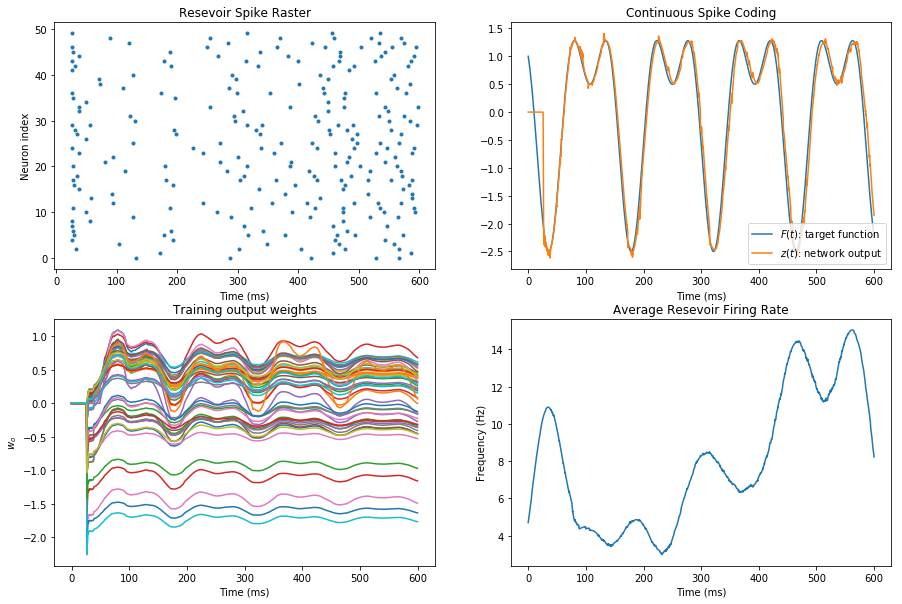

In [7]:
################################################################################
# Plot output of training phase
################################################################################
figure(figsize=[15,10])
subplot(221)
plot(resSpikeMon.t/ms, resSpikeMon.i,'.')
title('Resevoir Spike Raster')
xlabel('Time (ms)')
ylabel('Neuron index')
#show()

subplot(222)
plot(inMon.t/ms, inMon.F.flatten(),label='$F(t)$: target function')
plot(outMon.t/ms, outMon.z.flatten(),label='$z(t)$: network output')
title('Continuous Spike Coding')
xlabel('Time (ms)')
legend(loc='lower right')
#show()

subplot(223)
for i in range(N):
    plot(woMon.t/ms,woMon.wo[i])
title('Training output weights')
xlabel('Time (ms)')
ylabel('$w_o$')
#show()

subplot(224)
plot(resRateMon.t/ms, resRateMon.smooth_rate(width=25*ms)/Hz)
title('Average Resevoir Firing Rate')
xlabel('Time (ms)')
ylabel('Frequency (Hz)')
show()

Here, we see the output of the network. At the top left, we see the spike raster of all neurons in the resevoir. Note that spike rate visibly increaeses as training goes on. To the bottom left, we see the evolution of output weights over time. Here, we can see that the dynamics of the FORCE algorithm are quite fast, as compared to the temporal evolution of the network in general (as required by the FORCE algorithm). At bottom right, we see the firing rate of the resevoir, averaged over all neurons in the resevoir and with a $25ms$ sliding window. Again, note the increase in firing rate during training. Finally, at top right, we see the network output $z(t) = w_or(t)$ compared to the target function $F(t)$.

Increasing the number of neurons $N$ and decreasing time constants $\lambda_v$ and $\lambda_s$ makes the network output even smoother, though it also greatly increases the overall spike count / spike rate. We can compare the above, where $N=50$, to the following run with $N=100$:

![N = 100](N100.png)

---

Let's look more closely at the target function and network output:

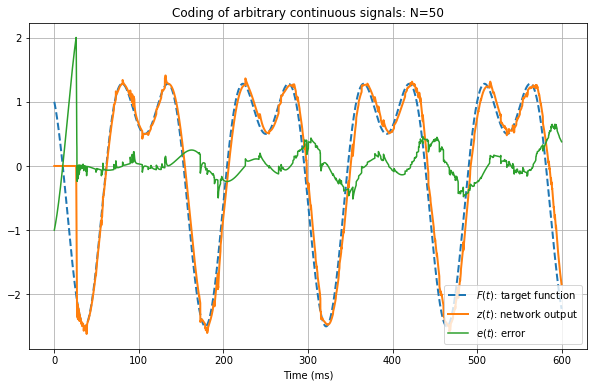

In [8]:
figure(figsize=[10,6])

plot(inMon.t/ms, inMon.F.flatten(),ls='--',lw=2,label='$F(t)$: target function')
plot(outMon.t/ms, outMon.z.flatten(),lw=2,label='$z(t)$: network output')
plot(outMon.t/ms, outMon.z.flatten() - inMon.F.flatten(), label='$e(t)$: error')
grid()
title('Coding of arbitrary continuous signals: N={}'.format(N))
xlabel('Time (ms)')
legend(loc='lower right')
#xlim([0,400])
show()

Notice how the error decreases initially, then begins to increase with a periodic pattern. This is due to the slight accumulated delay of the network; as time continues, there is a larger and larger phase shift between $z(t)$ and $F(t)$. If we continue training indefinitely with this periodic driving function, the phase-shifted error eventually causes a large attenuation of network output $z(t)$.

---

## Recreating Fig 1b, 1d

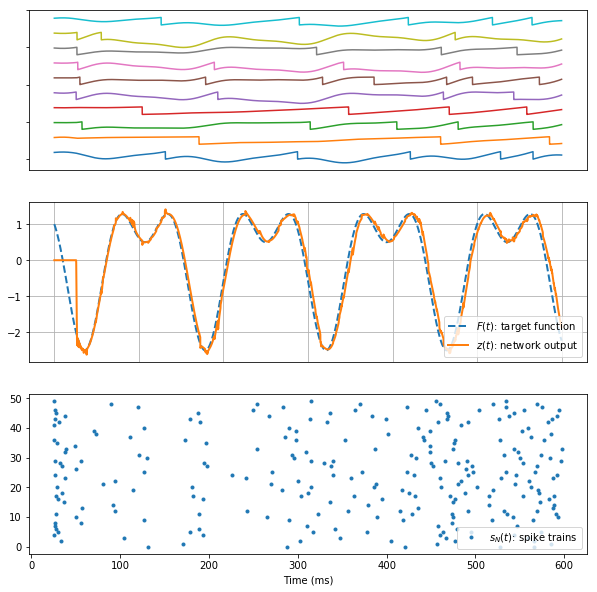

In [9]:
figure(figsize=[10,10])
subplot(3,1,1)
for i in range(10):
    plot(resMon.t/ms, resMon.V[i]+0.2*i)
xlabel('')
tick_params(bottom=False, labelbottom=False, labelleft=False)#xlim([0,600])

subplot(3,1,2)
plot(inMon.t/ms, inMon.F.flatten(),ls='--',lw=2,label='$F(t)$: target function')
plot(outMon.t/ms, outMon.z.flatten(),lw=2,label='$z(t)$: network output')
tick_params(bottom=False, labelbottom=False)
legend(loc='lower right')
grid()

subplot(3,1,3)
plot(resSpikeMon.t/ms, resSpikeMon.i,'.', label='$s_N(t)$: spike trains')
#ylabel('Spike trains: $s_N(t)$')
xlabel('Time (ms)')
legend(loc='lower right')
show()

---

### Self-sustained activity?

The true hallmark of spike-based universal computation is self-sustained activity, without any driving function input. Now that we've trained the network, we can attempt to elicit continued periodic output.

Unfortunately, one drawback of the paper is a lack of clear input to the system. In the case of modeling a weighted pendulum, they describe an exploratory white noise input. Otherwise, no clear decription for model input during the testing phase is given. I have attempted here to input Gaussian random noise to elicit a response; as you can see below, however, this is not successful.

In [10]:
store('after_training')

In [11]:
################################################################################
# Testing phase
################################################################################

restore('after_training')

# Turn off synaptic plasticity in output weights
outsyn.plastic = False

# Switch input neuron from signal to Gaussian noise with amplitude `noiseAmp`
inneur.training = False
inneur.noiseAmp = 0.1

In [12]:
# Run for 100 ms
testDur = 200*ms
run(testDur)

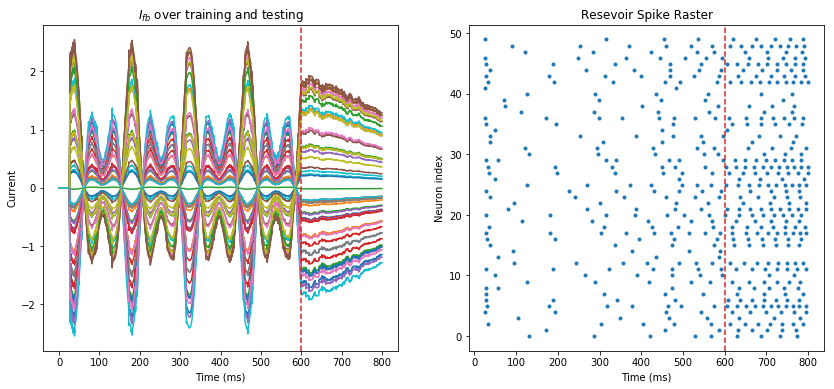

In [13]:
# Plot feedback current
figure(figsize=[14,6])
subplot(121)
for i in range(N):
    plot(resMon.t/ms, resMon.Ifb[i])
axvline((resMon.t[-1] - testDur)/ms, ls='--',c='C3')
xlabel('Time (ms)')
ylabel('Current')
title('$I_{fb}$ over training and testing')

subplot(122)
plot(resSpikeMon.t/ms, resSpikeMon.i,'.')
axvline((resMon.t[-1] - testDur)/ms, ls='--',c='C3')
title('Resevoir Spike Raster')
xlabel('Time (ms)')
ylabel('Neuron index')
show()

To view our output, let's now plot the feedback currents: note the periodic signal (based on network output) before the testing phase begins (vertical red dashed line), versus the random growing noise during the testing phase. We also see a rapid increase in spike rate, despite not truly encoding our signal. 

Finally, our (unsuccessful) output function:

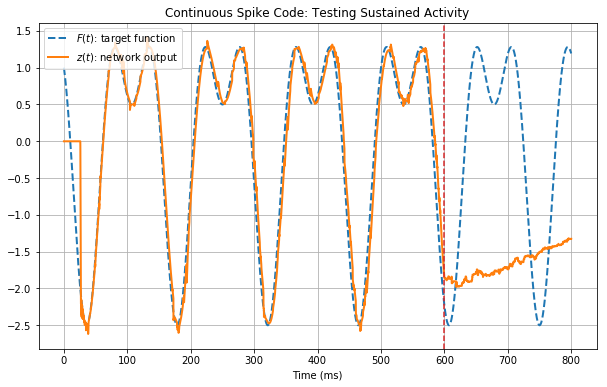

In [14]:
figure(figsize=[10,6])
plot(outMon.t/ms, cos(28 * pi * Hz * outMon.t) - 1.5 * sin(14 * pi * Hz * outMon.t),ls='--',lw=2,label='$F(t)$: target function')
plot(outMon.t/ms, outMon.z.flatten(),lw=2,label='$z(t)$: network output')
axvline((resMon.t[-1] - testDur)/ms, ls='--',c='C3')
legend(loc='upper left')
title('Continuous Spike Code: Testing Sustained Activity')
xlabel('Time (ms)')
grid()
show()

----

## Conclusions

The universal spike-based computation described in Thalmeier *et al.*, 2016 is quite interesting. In particular, it seems to be amenable to a wider range of neuron models than similar models (like the Machens & Deneve, 2016 model I implemented in my qualifying exam). However, I believe that the Deneve approach is more elegant than this spike coding approach. Here, though the authors describe this system as "spike coding," the timing relation between individual spikes is not enforced. In other words, the authors do not enforce the tight temporal coupling between excitation and inhibition that marks the Deneve computation approach. As such, sparsity is not controlled as directly in the approach demonstrated here.

That said, this training method is far more efficient than the post-hoc $l_2$-minimization described in Abbott *et al*, 2016. In fact, on-line FORCE learning and recursive least squares optimization could perhaps be usefully implemented in those rate-based coding methods.

I write "spike coding" here in scare quotes because information is not direcly encoded in order of spikes, or in time interval between spikes of different neurons, but in summed post-synaptic fluctuations of the neurons $r(t)$. In my opinion, this is much closer to the rate-coded networks described in Abbott *et al.*, 2016 (or DePasquale, Churchland, and Abbott 2016) than Deneve's spike coding network. Even after implementing these spike coding network, I am still partial to Deneve's tightly-balanced networks.